Data exploration and analysis
===================

Here we are going to explore the SBB dataset _is-daten-sbb_. We are going to select the features that can be of use for the rest of the project, clean the dataset if it needs to be and then compute some statistics on it.

## Imports

In [76]:
%matplotlib inline
import pandas as pd
print('pandas: {}'.format(pd.__version__))
import numpy as np
print('numpy: {}'.format(np.__version__))
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
import geopy as geo
print('geopy: {}'.format(geo.__version__))
import datetime

import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import powerlaw

from sklearn import preprocessing
from geopy import distance
from statistics import mean, median, stdev
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error,classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
from matplotlib.lines import Line2D

pandas: 0.25.3
numpy: 1.16.5
seaborn: 0.9.0
geopy: 1.20.0


## Extraction

In [2]:
filepath='./data/ist-daten-sbb.csv'
df=pd.read_csv(filepath,delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61716 entries, 0 to 61715
Data columns (total 26 columns):
BETRIEBSTAG            61716 non-null object
FAHRT_BEZEICHNER       61716 non-null object
BETREIBER_ID           61716 non-null object
BETREIBER_ABK          61716 non-null object
BETREIBER_NAME         61716 non-null object
PRODUKT_ID             61636 non-null object
LINIEN_ID              61716 non-null int64
LINIEN_TEXT            61716 non-null object
UMLAUF_ID              0 non-null float64
VERKEHRSMITTEL_TEXT    61716 non-null object
ZUSATZFAHRT_TF         61716 non-null bool
FAELLT_AUS_TF          61716 non-null bool
BPUIC                  61716 non-null int64
HALTESTELLEN_NAME      61716 non-null object
ANKUNFTSZEIT           56478 non-null object
AN_PROGNOSE            52344 non-null object
AN_PROGNOSE_STATUS     61716 non-null object
ABFAHRTSZEIT           56477 non-null object
AB_PROGNOSE            52343 non-null object
AB_PROGNOSE_STATUS     61716 non-null object


The dataset contains 26 columns which will be not of use to us. we will now discuss the meaning of these columns and translate them.
The rows correspond to an arrival and departure of a train from one station.

| Column |     Description     | New name/drop |
| :---: | :--- | :--- |
| BETRIEBSTAG | is the day the train departed but there is some inconsistencies as some trains departs after midnight in the day after |departure_day |
|  FAHRT_BEZEICHNER | is an unique indicator for a given train which doesn't seem that useful since LINIEN_ID does that also | Dropped |
|  BETREIBER_ID | is the id of the operator of the train which is always SBB in this dataset | Dropped |
|  BETREIBER_ABK | is the abrevation of the operator as above it is always SBB | Dropped |
|  BETREIBER_NAME | is the full name of the operator | Dropped |
|  PRODUKT_ID | is an id that tells us the type of transport it is. It's always trains apart from a few missing values that should also be trains | product_id |
|  LINIEN_ID | is an id for a given course | course_id |
|  LINIEN_TEXT | is the type of course | transport_type |
|  UMLAUF_ID | is an ID that tells us if there as been any changes in the programmation. It is always null | Dropped |
|  VERKEHRSMITTEL_TEXT | is just LINIEN_TEXT without the number at the end | Dropped |
|  ZUSATZFAHRT_TF | is a boolean that tells us if the train was not planned ahead | planned |
|  FAELLT_AUS_TF | is a boolean that tells us if the train was down | down |
|  BPUIC | is the service number | BPUIC |
|  HALTESTELLEN_NAME | is the name of the station | station_name |
|  ANKUNFTSZEIT | is the planned arrival time of the train at that station |planned_arrival_time|
|  AN_PROGNOSE | is the actual arrival time of the train | actual_arrival_time |
|  AN_PROGNOSE_STATUS | is an indicator of the deletion of the arrival of the train | cancelled_arrival |
|  ABFAHRTSZEIT | is the planned departure time of the train |planned_departure_time|
|  AB_PROGNOSE | is the actual departure time of the train |actual_departure_time|
|  AB_PROGNOSE_STATUS | is an indicator of the deletion of the departure of the train |cancelled_departure |
|  DURCHFAHRT_TF | don't know what it is but it is always false | Dropped |
|  ankunftsverspatung | is a boolean that tells us if the arrival of the train was delayed |arrival_delayed|
|  abfahrtsverspatung | is a boolean that tells us if the departure of the train was delayed |departure_delayed|
|  lod | is a link to a webpage that tells us more information about station | Dropped |
|  geopos | is the geoposition of the station | geopos |
|  GdeNummer | don't know | Dropped |

## Data preprocessing
We are going to drop some columns and rename the remaining ones.


In [4]:
df.drop(['lod','GdeNummer','DURCHFAHRT_TF','UMLAUF_ID','BETREIBER_NAME','BETREIBER_ABK','BETREIBER_ID','FAHRT_BEZEICHNER','VERKEHRSMITTEL_TEXT'],axis=1,inplace=True)
df.columns=['departure_day','product_id','course_id','transport_type','planned','down','BPUIC','station_name','planned_arrival_time',\
          'actual_arrival_time','cancelled_arrival','planned_departure_time','actual_departure_time','cancelled_departure','arrival_delayed','departure_delayed','geopos']
df.sample(5)

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
19382,2019-11-02,Zug,25692,S20,False,False,8505404,Cadenazzo,2019-11-03T00:15:00,2019-11-03T00:15:50,REAL,2019-11-03T00:15:00,2019-11-03T00:16:38,REAL,False,False,"46.1526250436,8.94168850732"
51285,2019-11-02,Zug,11600,S6,False,False,8503230,Glarus,2019-11-03T00:40:00,2019-11-03T00:40:54,REAL,2019-11-03T00:42:00,2019-11-03T00:42:21,REAL,False,False,"47.0399200317,9.0715516467"
17203,2019-11-02,Zug,1984,IR36,False,False,8500309,Brugg AG,2019-11-02T20:00:00,2019-11-02T20:04:23,REAL,2019-11-02T20:02:00,2019-11-02T20:06:10,REAL,True,True,"47.4808528316,8.20882744791"
33722,2019-11-02,Zug,26053,R,False,False,8500294,Balsthal,2019-11-02T14:26:00,2019-11-02T14:26:00,PROGNOSE,NaN,NaN,PROGNOSE,False,False,"47.3128885029,7.69391394062"
6967,2019-11-02,Zug,19521,S15,False,False,8503020,Zürich Hardbrücke,2019-11-02T06:04:00,2019-11-02T06:04:20,REAL,2019-11-02T06:04:00,2019-11-02T06:04:57,REAL,False,False,"47.3851946908,8.51710646094"


### Type conversion

We casted the date columns from string to datetime. We also considered to cast *geopos* but it's not required to use `geopy`.

In [5]:
df['planned_arrival_time'] =pd.to_datetime(df['planned_arrival_time'])
df['actual_arrival_time'] =pd.to_datetime(df['actual_arrival_time'])
df['planned_departure_time'] =pd.to_datetime(df['planned_departure_time'])
df['actual_departure_time'] =pd.to_datetime(df['actual_departure_time'])

In [6]:
location1 = df.loc[df['course_id'] == 30060].iloc[0]['geopos']
location2 = df.loc[df['course_id'] == 30060].iloc[1]['geopos']
#Excepted distance: 8 km (source: https://www.lexilogos.com/calcul_distances.htm)
print('location 1: ({}), location 2: ({}), distance: {} km'
      .format(location1, location2, round(geo.distance.distance(location1, location2).km),2))

location 1: (46.3983659275,6.92699984758), location 2: (46.4554432937,6.85953018827), distance: 8 km


In [7]:
#Translation of transport
df['product_id'].replace('Zug', 'train', inplace=True)

In [8]:
#Analyze the NaT values for arrival and departure time
df.loc[df['course_id'] == 30060].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
10497,2019-11-02,train,30060,S3,True,False,8501303,Villeneuve,NaT,NaT,PROGNOSE,2019-11-02 15:52:00,2019-11-02 15:52:54,REAL,False,False,"46.3983659275,6.92699984758"
22493,2019-11-02,train,30060,S3,True,False,8501300,Montreux,2019-11-02 15:56:00,2019-11-02 15:56:18,REAL,2019-11-02 15:56:00,2019-11-02 15:57:32,REAL,False,False,"46.4358743527,6.91043275261"
34234,2019-11-02,train,30060,S3,True,False,8501203,Clarens,2019-11-02 15:57:00,2019-11-02 15:58:22,REAL,2019-11-02 15:57:00,2019-11-02 15:59:37,REAL,False,False,"46.442731817,6.895777987"
22495,2019-11-02,train,30060,S3,True,False,8501202,Burier,2019-11-02 15:59:00,2019-11-02 16:02:01,REAL,2019-11-02 15:59:00,2019-11-02 16:02:50,REAL,True,True,"46.4478763825,6.87711567196"
10498,2019-11-02,train,30060,S3,True,False,8501201,La Tour-de-Peilz,2019-11-02 16:01:00,2019-11-02 16:04:20,REAL,2019-11-02 16:01:00,2019-11-02 16:04:51,REAL,True,True,"46.4554432937,6.85953018827"
22497,2019-11-02,train,30060,S3,True,False,8501200,Vevey,2019-11-02 16:07:00,2019-11-02 16:05:31,REAL,2019-11-02 16:07:00,2019-11-02 16:07:39,REAL,False,False,"46.4629974303,6.84345000982"
10499,2019-11-02,train,30060,S3,True,False,8501124,Cully,2019-11-02 16:14:00,2019-11-02 16:13:58,REAL,2019-11-02 16:14:00,2019-11-02 16:14:56,REAL,False,False,"46.488550014,6.72714757327"
33245,2019-11-02,train,30060,S3,True,False,8501122,Lutry,2019-11-02 16:17:00,2019-11-02 16:17:17,REAL,2019-11-02 16:17:00,2019-11-02 16:18:26,REAL,False,False,"46.5037789699,6.69061164399"
22499,2019-11-02,train,30060,S3,True,False,8501121,Pully,2019-11-02 16:20:00,2019-11-02 16:19:43,REAL,2019-11-02 16:20:00,2019-11-02 16:21:16,REAL,False,False,"46.5109189922,6.65946254087"
22501,2019-11-02,train,30060,S3,True,False,8501120,Lausanne,2019-11-02 16:24:00,2019-11-02 16:23:28,REAL,2019-11-02 16:33:00,2019-11-02 16:33:32,REAL,False,False,"46.5167786487,6.62909314109"


That shows it's normal to have NaT values for the date fields since the start point of the train has no arrival time and the arrival station has no planned departure.

Now looking at the cancelled departure we remark that it takes value PROGNOSE when it has no departure or arrival time which could either mean that it is the start of the line, the end of the line or that the train was really cancelled.

In [9]:
df.loc[df['course_id'] == 3260].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
35127,2019-11-02,train,3260,IR13,False,False,8509000,Chur,NaT,NaT,PROGNOSE,2019-11-02 07:12:00,NaT,PROGNOSE,False,False,"46.8530797552,9.52892561961"
20804,2019-11-02,train,3260,IR13,False,False,8509002,Landquart,2019-11-02 07:20:00,NaT,PROGNOSE,2019-11-02 07:22:00,NaT,PROGNOSE,False,False,"46.9674389764,9.55402859224"
23547,2019-11-02,train,3260,IR13,False,False,8509004,Bad Ragaz,2019-11-02 07:26:00,NaT,PROGNOSE,2019-11-02 07:27:00,NaT,PROGNOSE,False,False,"47.0103066077,9.50521579767"
23550,2019-11-02,train,3260,IR13,False,False,8509411,Sargans,2019-11-02 07:32:00,NaT,PROGNOSE,2019-11-02 07:36:00,2019-11-02 07:39:32,REAL,False,True,"47.0453635269,9.44539562754"
20806,2019-11-02,train,3260,IR13,False,False,8509404,Buchs SG,2019-11-02 07:45:00,2019-11-02 07:47:59,REAL,2019-11-02 07:45:00,2019-11-02 07:48:54,REAL,False,True,"47.1684089962,9.47862968189"
10899,2019-11-02,train,3260,IR13,False,False,8506319,Altstätten SG,2019-11-02 08:00:00,2019-11-02 08:02:28,REAL,2019-11-02 08:01:00,2019-11-02 08:03:23,REAL,False,False,"47.3742291734,9.55651096481"
34011,2019-11-02,train,3260,IR13,False,False,8506317,Heerbrugg,2019-11-02 08:06:00,2019-11-02 08:07:31,REAL,2019-11-02 08:07:00,2019-11-02 08:08:52,REAL,False,False,"47.4103853071,9.62724352946"
34013,2019-11-02,train,3260,IR13,False,False,8506314,St. Margrethen,2019-11-02 08:13:00,2019-11-02 08:12:50,REAL,2019-11-02 08:13:00,2019-11-02 08:13:41,REAL,False,False,"47.4532118157,9.63825154068"
23553,2019-11-02,train,3260,IR13,False,False,8506311,Rorschach,2019-11-02 08:21:00,2019-11-02 08:20:23,REAL,2019-11-02 08:21:00,2019-11-02 08:23:09,REAL,False,False,"47.4779984016,9.50513168035"
35130,2019-11-02,train,3260,IR13,False,False,8506302,St. Gallen,2019-11-02 08:35:00,2019-11-02 08:35:10,REAL,2019-11-02 08:37:00,NaT,PROGNOSE,False,False,"47.4231790668,9.36987712043"


What we see from this sample is that if the train is really cancelled the it has a planned arrival/departure time but not an actual. So we will change the values from cancelled arrival/departure to *Cancelled, Startpoint, Endpoint and somethingtosaynoproblem*.

In [10]:
df.at[(df.planned_arrival_time.isnull()) & (df.actual_arrival_time.isnull()),"cancelled_arrival"]="Startpoint"
df.at[(~df.planned_arrival_time.isnull()) & (df.actual_arrival_time.isnull()),"cancelled_arrival"]="Cancelled"
df.at[(~df.planned_arrival_time.isnull()) & (~df.actual_arrival_time.isnull()),"cancelled_arrival"]="Okay"
df.at[(df.planned_departure_time.isnull()) & (df.actual_departure_time.isnull()),"cancelled_departure"]="Endpoint"
df.at[(~df.planned_departure_time.isnull()) & (df.actual_departure_time.isnull()),"cancelled_departure"]="Cancelled"
df.at[(~df.planned_departure_time.isnull()) & (~df.actual_departure_time.isnull()),"cancelled_departure"]="Okay"

In [11]:
df.loc[df['course_id'] == 3260].sort_values(by='planned_departure_time')

,departure_day,product_id,course_id,transport_type,planned,down,BPUIC,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,planned_departure_time,actual_departure_time,cancelled_departure,arrival_delayed,departure_delayed,geopos
35127,2019-11-02,train,3260,IR13,False,False,8509000,Chur,NaT,NaT,Startpoint,2019-11-02 07:12:00,NaT,Cancelled,False,False,"46.8530797552,9.52892561961"
20804,2019-11-02,train,3260,IR13,False,False,8509002,Landquart,2019-11-02 07:20:00,NaT,Cancelled,2019-11-02 07:22:00,NaT,Cancelled,False,False,"46.9674389764,9.55402859224"
23547,2019-11-02,train,3260,IR13,False,False,8509004,Bad Ragaz,2019-11-02 07:26:00,NaT,Cancelled,2019-11-02 07:27:00,NaT,Cancelled,False,False,"47.0103066077,9.50521579767"
23550,2019-11-02,train,3260,IR13,False,False,8509411,Sargans,2019-11-02 07:32:00,NaT,Cancelled,2019-11-02 07:36:00,2019-11-02 07:39:32,Okay,False,True,"47.0453635269,9.44539562754"
20806,2019-11-02,train,3260,IR13,False,False,8509404,Buchs SG,2019-11-02 07:45:00,2019-11-02 07:47:59,Okay,2019-11-02 07:45:00,2019-11-02 07:48:54,Okay,False,True,"47.1684089962,9.47862968189"
10899,2019-11-02,train,3260,IR13,False,False,8506319,Altstätten SG,2019-11-02 08:00:00,2019-11-02 08:02:28,Okay,2019-11-02 08:01:00,2019-11-02 08:03:23,Okay,False,False,"47.3742291734,9.55651096481"
34011,2019-11-02,train,3260,IR13,False,False,8506317,Heerbrugg,2019-11-02 08:06:00,2019-11-02 08:07:31,Okay,2019-11-02 08:07:00,2019-11-02 08:08:52,Okay,False,False,"47.4103853071,9.62724352946"
34013,2019-11-02,train,3260,IR13,False,False,8506314,St. Margrethen,2019-11-02 08:13:00,2019-11-02 08:12:50,Okay,2019-11-02 08:13:00,2019-11-02 08:13:41,Okay,False,False,"47.4532118157,9.63825154068"
23553,2019-11-02,train,3260,IR13,False,False,8506311,Rorschach,2019-11-02 08:21:00,2019-11-02 08:20:23,Okay,2019-11-02 08:21:00,2019-11-02 08:23:09,Okay,False,False,"47.4779984016,9.50513168035"
35130,2019-11-02,train,3260,IR13,False,False,8506302,St. Gallen,2019-11-02 08:35:00,2019-11-02 08:35:10,Okay,2019-11-02 08:37:00,NaT,Cancelled,False,False,"47.4231790668,9.36987712043"


In [13]:
#now we create another DataFrame that is Line centric 
#needs the delay to be computed
dfline=df.sort_values(by='planned_departure_time').groupby("course_id").agg({'station_name':lambda x: list(x),'planned_arrival_time':\
    lambda x: list(x),'actual_arrival_time': lambda x: list(x),'cancelled_arrival':lambda x: list(x),'arrival_delayed': lambda x:\
     list(x),'actual_departure_time': lambda x: list(x),'planned_departure_time': lambda x: list(x),'cancelled_departure': lambda\
     x: list(x),'departure_delayed': lambda x: list(x),'geopos': lambda x:list(x),'departure_delay': lambda x: list(x),\
      'arrival_delay': lambda x: list(x)})

In [14]:
arri=[True in arr for arr in dfline.arrival_delayed]
depa=[True in arr for arr in dfline.departure_delayed]
dfline.arrival_delayed=arri
dfline.departure_delayed=depa

In [15]:
dfline.arrival_delay=dfline.arrival_delay.apply(max)
dfline.departure_delay=dfline.departure_delay.apply(max)

In [16]:
dfline.head(5)

,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,arrival_delayed,actual_departure_time,planned_departure_time,cancelled_departure,departure_delayed,geopos,departure_delay,arrival_delay
course_id,,,,,,,,,,,,
3,"[Basel SBB, Zürich HB]","[NaT, 2019-11-02 09:00:00]","[NaT, 2019-11-02 09:00:34]","[Startpoint, Okay]",False,"[2019-11-02 08:08:54, NaT]","[2019-11-02 08:07:00, NaT]","[Okay, Endpoint]",False,"[47.5474041527,7.58955146721, 47.3781765756,8....",00:01:54,00:00:34
4,"[Zürich HB, Basel SBB, Basel Bad Bf]","[NaT, 2019-11-02 19:53:00, 2019-11-02 20:19:00]","[NaT, 2019-11-02 19:53:50, 2019-11-02 20:22:06]","[Startpoint, Okay, Okay]",True,"[2019-11-02 19:01:51, 2019-11-02 20:17:07, 201...","[2019-11-02 19:00:00, 2019-11-02 20:13:00, 201...","[Okay, Okay, Okay]",True,"[47.3781765756,8.54019221036, 47.5474041527,7....",00:04:07,00:03:06
5,"[Basel Bad Bf, Basel SBB]","[2019-11-02 09:34:00, 2019-11-02 09:47:00]","[2019-11-02 09:34:00, 2019-11-02 09:56:31]","[Okay, Okay]",True,"[2019-11-02 09:46:14, NaT]","[2019-11-02 09:40:00, NaT]","[Okay, Endpoint]",True,"[47.5681463635,7.60728432529, 47.5474041527,7....",00:06:14,00:09:31
6,"[Interlaken Ost, Interlaken West, Spiez, Thun,...","[NaT, 2019-11-02 12:03:00, 2019-11-02 12:21:00...","[NaT, 2019-11-02 12:04:33, 2019-11-02 12:21:09...","[Startpoint, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[2019-11-02 12:00:39, 2019-11-02 12:05:54, 201...","[2019-11-02 12:00:00, 2019-11-02 12:05:00, 201...","[Okay, Okay, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[46.6905054601,7.86900513744, 46.6826271766,7....",00:03:02,00:03:10
7,"[Basel Bad Bf, Basel SBB, Liestal, Olten, Bern...","[2019-11-02 13:22:00, 2019-11-02 13:30:00, 201...","[2019-11-02 13:22:00, 2019-11-02 13:44:06, 201...","[Okay, Okay, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[2019-11-02 13:38:33, 2019-11-02 14:00:42, 201...","[2019-11-02 13:24:00, 2019-11-02 13:59:00, 201...","[Okay, Okay, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[47.5681463635,7.60728432529, 47.5474041527,7....",00:14:33,00:14:06


In [17]:
dfline.loc[[("Startpoint" not in arr) for arr in dfline.cancelled_arrival]].head(5)

,station_name,planned_arrival_time,actual_arrival_time,cancelled_arrival,arrival_delayed,actual_departure_time,planned_departure_time,cancelled_departure,departure_delayed,geopos,departure_delay,arrival_delay
course_id,,,,,,,,,,,,
5,"[Basel Bad Bf, Basel SBB]","[2019-11-02 09:34:00, 2019-11-02 09:47:00]","[2019-11-02 09:34:00, 2019-11-02 09:56:31]","[Okay, Okay]",True,"[2019-11-02 09:46:14, NaT]","[2019-11-02 09:40:00, NaT]","[Okay, Endpoint]",True,"[47.5681463635,7.60728432529, 47.5474041527,7....",00:06:14,00:09:31
7,"[Basel Bad Bf, Basel SBB, Liestal, Olten, Bern...","[2019-11-02 13:22:00, 2019-11-02 13:30:00, 201...","[2019-11-02 13:22:00, 2019-11-02 13:44:06, 201...","[Okay, Okay, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[2019-11-02 13:38:33, 2019-11-02 14:00:42, 201...","[2019-11-02 13:24:00, 2019-11-02 13:59:00, 201...","[Okay, Okay, Okay, Okay, Okay, Okay, Okay, Oka...",True,"[47.5681463635,7.60728432529, 47.5474041527,7....",00:14:33,00:14:06
9,"[Basel Bad Bf, Basel SBB, Zürich HB]","[2019-11-02 15:27:00, 2019-11-02 15:35:00, 201...","[2019-11-02 15:27:00, 2019-11-02 15:43:14, 201...","[Okay, Okay, Okay]",True,"[2019-11-02 15:34:03, 2019-11-02 16:08:57, NaT]","[2019-11-02 15:29:00, 2019-11-02 16:07:00, NaT]","[Okay, Okay, Endpoint]",True,"[47.5681463635,7.60728432529, 47.5474041527,7....",00:05:03,00:08:14
32,"[Brig, Sion, Montreux, Lausanne, Genève]","[2019-11-02 10:16:00, 2019-11-02 10:45:00, 201...","[2019-11-02 10:26:54, 2019-11-02 10:53:21, 201...","[Okay, Okay, Okay, Okay, Cancelled]",True,"[2019-11-02 10:29:03, 2019-11-02 10:54:53, 201...","[2019-11-02 10:20:00, 2019-11-02 10:47:00, 201...","[Okay, Okay, Okay, Cancelled, Endpoint]",True,"[46.3194210071,7.98809158467, 46.2275453615,7....",00:09:03,00:10:54
34,"[Brig, Sion, Montreux, Lausanne, Genève]","[2019-11-02 14:16:00, 2019-11-02 14:45:00, 201...","[2019-11-02 14:24:38, 2019-11-02 14:51:53, 201...","[Okay, Okay, Okay, Okay, Cancelled]",True,"[2019-11-02 14:27:19, 2019-11-02 14:54:02, 201...","[2019-11-02 14:20:00, 2019-11-02 14:47:00, 201...","[Okay, Okay, Okay, Cancelled, Endpoint]",True,"[46.3194210071,7.98809158467, 46.2275453615,7....",00:07:19,00:08:38


There is some lines that do not have an endpoint or startpoint. Those trains come from other countries or go into other contries. Since we focus on the Swiss train network we will drop those.

In [18]:
inddrop1=dfline.loc[[("Startpoint" not in arr) for arr in dfline.cancelled_arrival]].index
dfline.drop(inddrop1,inplace=True)
inddrop2=dfline.loc[[("Endpoint" not in arr) for arr in dfline.cancelled_departure]].index
dfline.drop(inddrop2,inplace=True)

In [19]:

def contain_or_not(list_of_words): #function to know wheter a line contains the stations of the user in the good order
    contains= [True,0]
    if station_departure in list_of_words:
        b=list_of_words[list_of_words.index(station_departure):]
        if station_arrival in b:
            contains= [True,list_of_words.index(station_departure)]
        else:
            contains= [False, None]
    else:
        contains=[False, None]
    
    return contains

def line_return(station_departure,station_arrival):
    f=dfline['station_name'].apply(contain_or_not)
    f=f.tolist()
    f2 = [item[0] for item in f]
    f3=[item[1] for item in f]#usefull to get the planned departure time and actual departure time
    f3= [incom for incom in f3 if str(incom) != 'None'] #might be useffull to drop na's
    g=dfline[f2]#list of all lines that contain departure and arrival station in the good order.
    departure_times_list=[]
    for i, j in enumerate(f3):
        departure_times_list.append(g['planned_departure_time'].iloc[i][j])
    return g,departure_times_list



In [73]:
#preprocess the data to be usefull in the model
df1=df[["station_name","planned_arrival_time","departure_delay","departure_delayed"]].dropna()
x=df1[["station_name","planned_arrival_time"]]
y=df1["departure_delay"]
x1=pd.get_dummies(data=x)
x1["hour"]=x["planned_arrival_time"].apply(lambda x: x.hour).astype(int)
x1["minute"]=x["planned_arrival_time"].apply(lambda x: x.minute).astype(int)
x1['day']=x['planned_arrival_time'].apply(lambda x: x.day).astype(int)
x2=x1.loc[:, x1.columns!="planned_arrival_time"]
y1=y.apply(lambda x: (x.seconds//60)%60).astype(int)
x_train, x_test, y_train, y_test = train_test_split(x2, y1, test_size=0.3, random_state=9)

In [74]:
def computeErrorRidgeRegCV(x, y, k, alpha):
    # Split the set in k-folds
    kf = KFold(n_splits = k)
    mse_k = []
    mse_t=[]
    # For each configuration we compute the mean squared error
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        reg = Ridge(alpha = alpha)
        reg.fit(x_train, y_train)
        predict = reg.predict(x_test)
        mse_k.append(mean_squared_error(y_test, predict))
    return mean(mse_k)
def computeCrossValidationErrors(x, y, k, alphas):
    cve=[]
    for alpha in alphas:
        cve.append(computeErrorRidgeRegCV(x, y, k, alpha))
    return cve
alphas = range(1,10)
cve = computeCrossValidationErrors(x_train, y_train, 5, alphas)

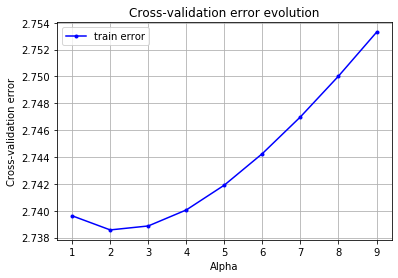

In [72]:
import matplotlib.pyplot as plt


"""Plot the cross-validation error as a function of the regularization parameter alpha

Args:
    alphas (list of float): List of values for the regularization parameter.
    cve (list of float): List of errors corresponding to the alphas.
"""
def cross_validation_error_visualization(alphas, cve):
    plt.plot(alphas, cve, marker=".", color='b', label='train error')
    plt.xlabel("Alpha")
    plt.ylabel("Cross-validation error")
    plt.title("Cross-validation error evolution")
    plt.legend(loc=0)
    plt.grid(True)
    
cross_validation_error_visualization(alphas, cve)

In [75]:
optimal_alpha = alphas[cve.index(min(cve))]
# Now we can use our test set and evaluate our model
model = Ridge(alpha = optimal_alpha)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print('Optimal alpha: {}\nFinal model mean squared error: {}'
      .format(optimal_alpha, np.round(mean_absolute_error(y_test, predict),3)))

Optimal alpha: 2
Final model mean squared error: 0.92


In [80]:
#we will try logistic regression to get probabilities of lateness so now the features will be the same and the output
#is a classifier departure_delayed
from sklearn.linear_model import LogisticRegression 
y=df1["departure_delayed"]
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size=0.3, random_state=1)
lr=LogisticRegression(random_state=0,solver="lbfgs",max_iter=500)
model=lr.fit(x_train,y_train)
model.score(x_test,y_test)

0.883203493862134

In [124]:
#more detailled report of the score of our
ypred=lr.predict(x_test)
print(classification_report(y_test,ypred,digits=3))

              precision    recall  f1-score   support

       False      0.890     0.989     0.937     14816
        True      0.659     0.145     0.238      2128

    accuracy                          0.883     16944
   macro avg      0.774     0.567     0.587     16944
weighted avg      0.861     0.883     0.849     16944



In [86]:
#interactiv part 
from difflib import SequenceMatcher
from datetime import *
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
def getinput():
    l=df.station_name.unique()
    station=input("enter the start station:")
    list=[]
    if ~(station in l):
        for name in l:
            list.append(similar(station,name))
        station=l[list.index(max(list))]
    time=input("enter the time(format d HH:MM):")
    time= datetime.strptime(time, '%d %H:%M')
    return station,time

In [119]:
#translate the input to one hot encode so that we can predict
def predictone():
    station,time=getinput()
    h=["hour","minute","day"]
    l=[]
    for name in x2.columns.to_list():
        if name.find(station)>-1:
            l.append(1)
        elif name in h:
            if name=="hour":
                l.append(time.hour)
            elif name=="minute":
                l.append(time.minute)
            else:
                l.append(time.day)
        else:
            l.append(0)
    l1=pd.Series(l,x2.columns.to_list())
    x=model.predict_proba(l1.values.reshape(1,-1))[:,1]
    print("Probability of delay:{0}".format(np.round(x[0],2)))
    

In [120]:
predictone()

enter the start station: cornaux
enter the time(format d HH:MM): 2 18:00


Probability of delay:0.25


## Delay Analysis

We had columns to store the delay of departure and arrival in order to make stats on it later.
We consider that a train that doesn't have a scheduled start, hasn't departure delay.  
Similarly, a train that arrives early has no negative delay, we set it to 0.

In [12]:
#Compute the delay of the departure
df['departure_delay'] = df['actual_departure_time'] - df['planned_departure_time']
#Set at 0 the delay when the train left in advance its station
df.loc[df.departure_delay < datetime.timedelta(0), 'departure_delay'] = datetime.timedelta(0)
#Replace the NaT values to 0
df.departure_delay.fillna(datetime.timedelta(0), inplace=True)


#Compute the delay of the arrival
df['arrival_delay'] = df['actual_arrival_time'] - df['planned_arrival_time']
#Set at 0 the delay when the train arrived in advance
df.loc[df.arrival_delay < datetime.timedelta(0), 'arrival_delay'] = datetime.timedelta(0)
#Replace the NaT values to 0£
df.arrival_delay.fillna(datetime.timedelta(0), inplace=True)

* What's the average time of delay?
* What's the max?

In [15]:
df['departure_delay'].mean().min
print("\tDeparture delay - average: {0}/max: {1}\n\tArrival delay - average: {2}/max: {3}"
     .format(df['departure_delay'].mean(), df['departure_delay'].max(),
                 df['arrival_delay'].mean(), df['arrival_delay'].max()))

	Departure delay - average: 0 days 00:01:33.649345/max: 0 days 00:57:51
	Arrival delay - average: 0 days 00:00:56.289600/max: 0 days 00:56:12


* What is the most common type of delay
* What's the proportion of departure delayed train?

In [16]:
dep_delayed = df.groupby(pd.Grouper(key = 'departure_delay', freq = '60s')).size()

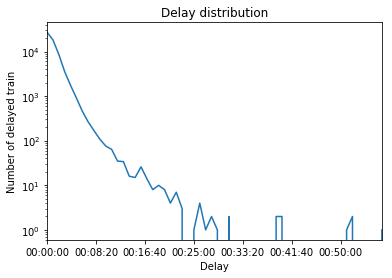

In [17]:
dep_delayed.plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution")
plt.yscale('log')
plt.show()

Even with a log scale, it's seems that most of the delayed trains are less than 3 minutes late.
Since his type of delay is not too penalizing for the users we choose to redefine the limit of the delay.  
*We now consider that a train is delayed from the moment it's over 3 min late.*

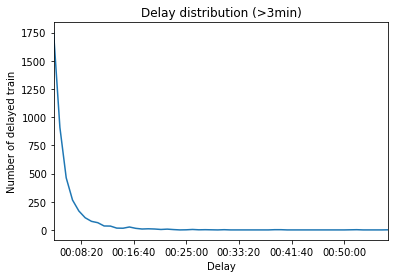

In [18]:
dep_delayed.loc[dep_delayed.index > datetime.timedelta(minutes=3)].plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution (>3min)")
plt.show()

We see that the delays are still mainly stuck between 3 minutes and 15 minutes.

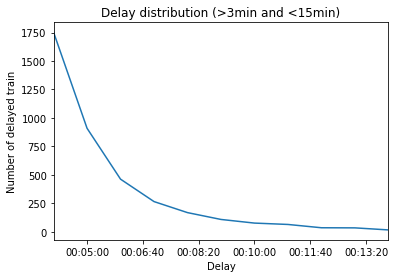

In [19]:
dep_delayed.loc[(dep_delayed.index > datetime.timedelta(minutes=3)) \
                & (dep_delayed.index < datetime.timedelta(minutes=15))].plot()
plt.xlabel("Delay")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution (>3min and <15min)")
plt.show()

In [20]:
# Compute the proportion of delayed train compare to other trains
proportion = dep_delayed.loc[(dep_delayed.index > datetime.timedelta(minutes=3))].sum() / dep_delayed.sum()
print('Proportion of delayed train (>3 min): {} %'.format(round(proportion * 100,2)))

Proportion of delayed train (>3 min): 6.49 %


* What time of the day are trains more likely to be late ?

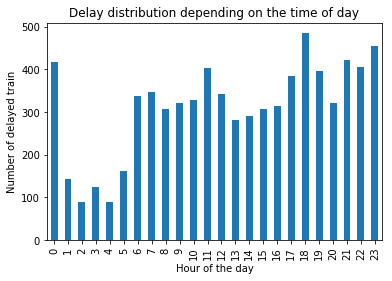

In [21]:
late = df.loc[df['departure_delay'] > datetime.timedelta(minutes=3), ['actual_departure_time']]
times = pd.DatetimeIndex(late['actual_departure_time'])
grouped = late.groupby([times.hour]).count()
grouped.plot(kind='bar', legend=None)
plt.xlabel("Hour of the day")
plt.ylabel("Number of delayed train")
plt.title("Delay distribution depending on the time of day")
plt.show()

There is a decrease in the number of delays in the period from midnight to 4am.  
Except this slot and the leaving work hour (~6pm), delays seem to have an uniform distribution.

* Does a late departing train necessarily have a late arrival delay? (Is there a strong correlation between depature and arrival delay?)

In [22]:
print('Correlation between departure and arrival delay: {}'.format(df['departure_delayed'].corr(df['arrival_delayed'])))

Correlation between departure and arrival delay: 0.5737142382601134


We observe that, even if the train is delayed at the beginning it's not necessarily late to the arrival. 

We now continue the analysis of delays per stations. We are interested in finding the stations with the most frequent delays.
* What is the average delay for each station? What's the maximum and minimum?
* Which are these stations?

In [23]:
dep_st = df.groupby(['station_name'])['departure_delay'].mean(numeric_only=False).reset_index()
arr_st = df.groupby(['station_name'])['arrival_delay'].mean(numeric_only=False).reset_index()
worst_d_st = dep_st.loc[dep_st['departure_delay'].idxmax()]
best_d_st = dep_st.loc[dep_st['departure_delay'].idxmin()]
worst_a_st = arr_st.loc[arr_st['arrival_delay'].idxmax()]
best_a_st = arr_st.loc[arr_st['arrival_delay'].idxmin()]
print("\tAverage departure delay - min: {0} --- {1}\n\t\t\t\t  max: {2} --- {3}\n\tAverage arrival delay - min: {4} --- {5}\n\t\t\t\tmax: {6} --- {7}"
     .format(best_d_st['departure_delay'], best_d_st['station_name'], worst_d_st['departure_delay'], worst_d_st['station_name'],
             best_a_st['arrival_delay'], best_a_st['station_name'], worst_a_st['arrival_delay'], worst_a_st['station_name']))

	Average departure delay - min: 0 days 00:00:00 --- Belfaux CFF
				  max: 0 days 00:06:21.800000 --- Hallwil
	Average arrival delay - min: 0 days 00:00:00 --- Balsthal
				max: 0 days 00:03:35.854545 --- Basel Bad Bf


* How many trains are delayed for each station? What is their percentage?

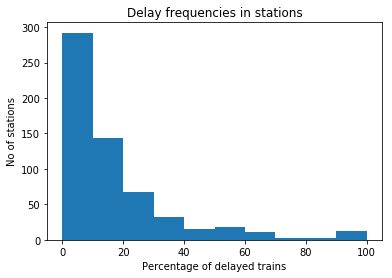

In [24]:
def compute_percentage(x):
    """Returns how many trains are delayed.
    A train is delayed if it departs at least 3 minutes after the 
    scheduled departure time.
    
    Arguments
    ---------
        x : pandas.Series
            inpute value
    
    Returns
    -------
        y
            New Series with percentage of delayed trains."""
    return x.loc[x > datetime.timedelta(minutes=3)].count() * 100 / x.count()    
    
delay_freq = df.groupby(['station_name', 'geopos'])['departure_delay'].apply(compute_percentage).reset_index()
delay_freq = delay_freq.rename(columns={'departure_delay': 'per_delayed_trains'})
delay_freq['geopos'] = delay_freq['geopos'].apply(lambda x: [x])

# Plot a histogram of delay frequencies in stations
delay_freq.plot(kind='hist', legend=None)
plt.xlabel("Percentage of delayed trains")
plt.ylabel("No of stations")
plt.title("Delay frequencies in stations")
plt.show()

In [25]:
delay_freq.head()

,station_name,geopos,per_delayed_trains
0,Aarau,"[47.3913553369,8.05125354274]",5.370844
1,Aarburg-Oftringen,"[47.3202667174,7.90820373354]",12.396694
2,Aathal,"[47.3359563788,8.76561022548]",5.813953
3,Aesch,"[47.4677359724,7.60305476436]",5.633803
4,Affoltern am Albis,"[47.276064074,8.44658239143]",2.758621


In [26]:
# First 5 stations with most trains delayed
print(delay_freq.sort_values(by='per_delayed_trains')[0:5])
# First 5 stations with most trains on time
print(delay_freq.sort_values(by='per_delayed_trains', ascending=False)[0:5])

         station_name                         geopos  per_delayed_trains
168         Faulensee  [46.6737594029,7.69790656091]                 0.0
224            Hinwil     [47.3000509,8.83969785564]                 0.0
528           Uerikon  [47.2358565197,8.75261073401]                 0.0
118            Couvet  [46.9233508976,6.63566843084]                 0.0
564  Winterthur Grüze  [47.4987506397,8.75103748096]                 0.0
      station_name                         geopos  per_delayed_trains
397  Ostermundigen  [46.9567955453,7.48148743552]               100.0
146       Düdingen   [46.8510429325,7.1897482223]               100.0
214       Gümligen  [46.9343142711,7.50550149434]               100.0
488       Sommerau  [47.4390111569,7.85146338126]               100.0
451      Rümlingen  [47.4253702718,7.85052282001]               100.0


We observe that most of the stations have between 0% and 40% of trains delayed. In this range, significantly more stations have between 0 and 10% delays.

## Geographic data plotting test

Since we want to plot some geograpic data from our dataset (network...), we tried with our subdataset.

In [27]:
# We create two new column from the geopos column
df['latitude'], df['longitude'] = df['geopos'].str.split(',', 1).str

# Type conversion
df['latitude'] = df['latitude'].astype('float')
df['longitude'] = df['longitude'].astype('float')

# We compute the area that will include all spatial points
BBox = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())
print('Geograpic plotting boundaries: ({0}, {2}) and ({1}, {3})'.format(BBox[0], BBox[1], BBox[2], BBox[3])) 

Geograpic plotting boundaries: (5.99999627842, 45.8321788009) and (9.63825154068, 47.6982814692)


We use this data to extract the corresponding area from: https://www.openstreetmap.org/  
We will now be able to plot our data.

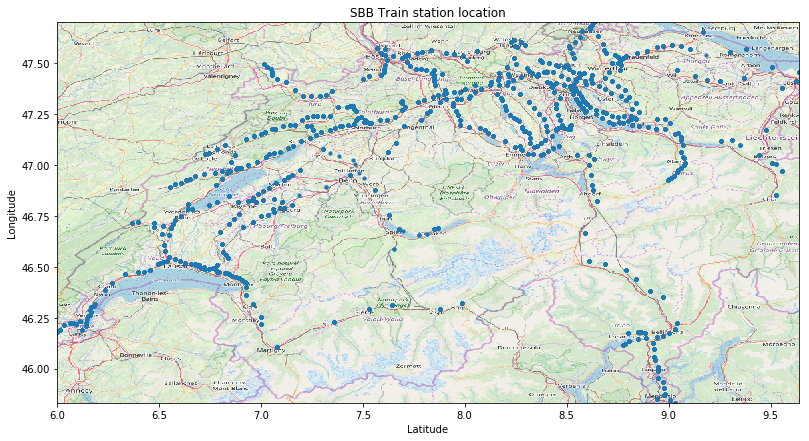

In [28]:
# Retrieve the image map
map = plt.imread('data/test_map.png')

# Create the figure and plot our data
fig, ax = plt.subplots(figsize = (15,7))
plt.scatter(df.longitude, df.latitude, s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map, extent = BBox)
ax.set_title('SBB Train station location')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Now we will try to plot the whole network by using our line centered dataset.  
We create two new columns in the dataset to store the list of longitudes and latitudes for each line of the dataset:

In [38]:
def split_geo_pos(df, geo_pos='geopos'):
    """
    Modifies a given dataframe by extracting longitude and latitude from
    geoposition and inserting them in two new columns.
    
    Arguments
    ---------
        df : pandas.Dataframe
             input dataframe
        geo_pos : string
                  name of geoposition column
    """
    
    all_lat = []
    all_long = []
    # For each row, we retrieve the longitude and latitude
    for i, row in df.iterrows():
        longitudes = []
        latitudes = []
        for pos in row['geopos']:
            lat, long = pos.split(',')
            # We need to convert str to float for the plotting part
            latitudes.append(float(lat))
            longitudes.append(float(long))
        all_lat.append(latitudes)
        all_long.append(longitudes)
    df['latitudes'] = all_lat
    df['longitudes'] = all_long
    
split_geo_pos(dfline)

Now we are able to plot the whole network:

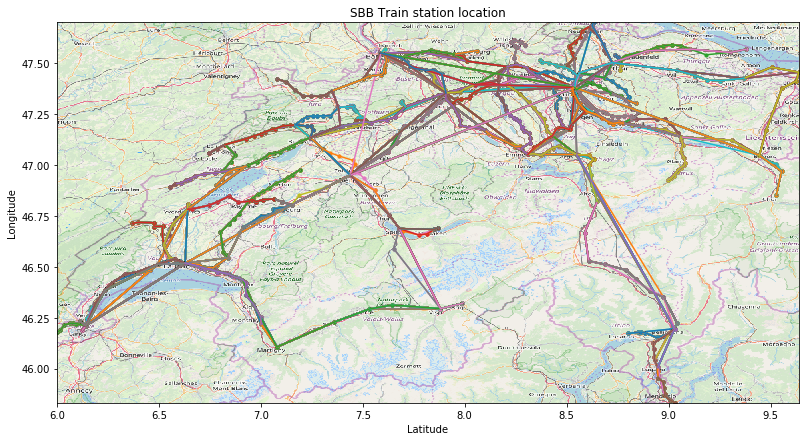

In [39]:
# Retrieve the image map
map = plt.imread('data/test_map.png')

# Create the figure and plot our data
fig, ax = plt.subplots(figsize = (15,7))

for i, row in dfline.iterrows():
    plt.scatter(row['longitudes'], row['latitudes'], s=10)
    plt.plot(row['longitudes'], row['latitudes'])

ax.imshow(map, extent = BBox)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('SBB Train station location')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()


*Some line trajectory seem quite strange but it's just because the train is a direct one. We only have the departure and arrival station so we can't represent the real trajectory.*  
Now we can also consider the delay for each line and observe the delay repartition through the network.  
To do that we create a new column to store the scale of delay for the train:

In [40]:
# We store the number of minutes of delay
dfline['delay_scale'] = dfline.apply(lambda row: row.departure_delay.seconds/60, axis=1)

# Since the color scale of matplotlib only handle values between 0 and 1, we have to normalized our new column 
min_max_scaler = preprocessing.MinMaxScaler()

# Normalize the column by fitting minmax processor
dfline['delay_scale'] = min_max_scaler.fit_transform(dfline['delay_scale'].values.reshape(-1, 1))
dfline['delay_scale'].sample(3)

course_id
8657     0.070980
20374    0.114950
3321     0.047739
Name: delay_scale, dtype: float64

We create a function that computes the color corresponding to the delay :
* **On time** - green
* **Less than 5min of delay** - yellow
* **5 - 15min of delay** - orange
* **more than 15 min of delay** - red

In [41]:
def getColor(value : float) -> str:
    """Return the color corresponding to the input value (color scale based on the delay).
    
    Arguments
    ---------
        m : float
            input value (between 0 and 1).
    
    Returns
    -------
        str
            the string corresponding to a matplotlib color.
    """
    if value == 0: #On time
        return 'g'
    if value < 0.188442 : #Less than 5 minutes of delay
        return 'y'
    elif value < 0.57 : #Less than 15 minutes of delay
        return 'orange'
    else : #More than 15 minutes of delay
        return 'r'

In [ ]:
#Retrieve the image map
map = plt.imread('data/test_map.png')

# Create the figure and plot our data
fig, ax = plt.subplots(figsize = (15,7))

for i, row in dfline.iterrows():
    color = getColor(row['delay_scale'])
    plt.scatter(row['longitudes'], row['latitudes'], c=color, s=10)
    plt.plot(row['longitudes'], row['latitudes'], c=color)
    
ax.imshow(map, extent = BBox)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('SBB Train station location')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
legend = [Line2D([0], [0], color='g', lw=4, label='On time'), Line2D([0], [0], color='y', lw=4, label='<5min of delay'),
Line2D([0], [0], color='orange', lw=4, label='5-15min of delay'), Line2D([0], [0], color='r', lw=4, label='>15min of delay')]
ax.legend(handles=legend, loc=0)
plt.show()

Now we can also consider the frequency of delays for each station and observe the delay repartition through the network.  
We will use the `delay_freq` Dataframe from computed in the Delay analysis section.
We create two new columns in the dataset to store the list of longitudes and latitudes for each station of the dataset, as we did with when we plotted the train lines.

In [ ]:
split_geo_pos(delay_freq)

In [ ]:
def getColorStations(value : int) -> str:
    """Return the color corresponding to the input value.
    Color is based on the perctange of delayed trains per station.
    
    Arguments
    ---------
        m : int
            input value (between 0 and 100).
    
    Returns
    -------
        str
            the string corresponding to a matplotlib color.
    """
    if value < 10:
        return 'g'
    if value < 30:
        return 'y'
    elif value < 60: 
        return 'orange'
    else:
        return 'r'

In [ ]:
#Retrieve the image map
map = plt.imread('data/test_map.png')

# Create the figure and plot our data
fig, ax = plt.subplots(figsize = (15,7))

for i, row in delay_freq.iterrows():
    color = getColorStations(row['per_delayed_trains'])
    plt.scatter(row['longitudes'], row['latitudes'], c=color, s=10)
    plt.plot(row['longitudes'], row['latitudes'], c=color)
    
ax.imshow(map, extent = BBox)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_title('SBB Train station location')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
legend = [Line2D([0], [0], color='g', lw=4, label=' <10% delayed trains'), Line2D([0], [0], color='y', lw=4, label='10%-30% delayed trains'),
Line2D([0], [0], color='orange', lw=4, label='30%-60% delayed trains'), Line2D([0], [0], color='r', lw=4, label='>60% delayed trains')]
ax.legend(handles=legend, loc=0)
plt.show()

## Reasons for the delays

As we are doing a data project on delays of the CFF trains, we are going to try to get some insight on what causes the delays and maybe find what kind of improvement can be done to reduce delays. We will do this using data set rail-traffic-information.csv. This data set is in english. It contains the most important information on rail traffic in Switzerland according to CFF. You can take a look of the data on the following link:
https://data.sbb.ch/explore/dataset/rail-traffic-information/table/?sort=-published

The column that are going to be relevent for us are 'Title', 'Description' and 'Published', the last one giving us when the delay annoncement was published. By looking carefully at the data we can see that a lot of delay information appear multiple times within minutes/hours and the description will tell that cancellations and delays are expected (not a precise number), which are factors that can bias our conclusions and make it hard to quantify exactly how much each delay reason impacts the traffic. Therefore even tough this dataset also contains columns that show us information between or near which stations the delays/cancellations might happen, we will not use it to try to quantify delays and cancellations for each station as we can use our "ist-daten-sbb.csv" data set for this purpose.  Nonetheless, this data set will allow us to see the "big picture" of what causes the delays.

In [ ]:
# Data extraction
filepath = 'rail-traffic-information.csv'
trail_info = pd.read_csv(filepath, delimiter=';')

In [4]:
trail_info.head(5)

,Title,Link,Description,Published,Author,Validitybegin,Validityend,description_html
0,End of announcement: Zürich Seebach - Regensdo...,http://fahrplan.sbb.ch/bin/help.exe/en?tpl=sho...,06.09.2019 00:00 - 07:40The disruption between...,2019-09-06T08:07:09+02:00,SBB,2019-09-06T02:00:00+02:00,2019-09-06T09:40:00+02:00,06.09.2019 00:00 - 07:40<br /><br />The disrup...
1,Restriction: Othmarsingen,http://fahrplan.sbb.ch/bin/help.exe/en?tpl=sho...,03.07.2018 00:00 - 13:40Train services at Othm...,2018-07-03T10:36:36+02:00,SBB,2018-07-03T02:00:00+02:00,2018-07-03T15:40:00+02:00,03.07.2018 00:00 - 13:40<br /><br />Train serv...
2,Disruption: Porrentruy - Boncourt,http://fahrplan.sbb.ch/bin/help.exe/en?tpl=sho...,04.07.2018 00:00 - 18:00Between Porrentruy and...,2018-07-04T15:25:26+02:00,SBB,2018-07-04T02:00:00+02:00,2018-07-04T20:00:00+02:00,04.07.2018 00:00 - 18:00<br /><br />Between Po...
3,End of announcement: Luino (I) - Maccagno,http://fahrplan.sbb.ch/bin/help.exe/en?tpl=sho...,24.06.2018 00:00 - 16:00The disruption between...,2018-06-24T13:12:23+02:00,SBB,2018-06-24T02:00:00+02:00,2018-06-24T18:00:00+02:00,24.06.2018 00:00 - 16:00<br /><br />The disrup...
4,End of announcement: Nyon - Coppet,http://fahrplan.sbb.ch/bin/help.exe/en?tpl=sho...,29.06.2018 00:00 - 14:15The disruption between...,2018-06-29T14:49:11+02:00,SBB,2018-06-29T02:00:00+02:00,2018-06-29T16:15:00+02:00,29.06.2018 00:00 - 14:15<br /><br />The disrup...


In [5]:
#order the data
trail_info=trail_info.sort_values(by='Published')

In [6]:
#remove the first 3000 rows
trail_info=trail_info.iloc[3000:]

We noticed that the number of annoncement about delays is a lot smaller in 2018 than in 2019. By analyzing further we found that the before november 2018, the frequence of annoncement is smaller, so we decided to remove the first 3000 rows which corresponds to removing data before november 2018. The most probable reason for this reduced frquence in annoncements is that the process was not complete before this date as SBB started to register those datas only around january 2018 and the frequency was extremly low at this time.

In [7]:
trail_info.shape

(11377, 8)

We can already get some information about the delays with the title column only. There are five kinds of title:"Construction work","Restriction", "Disruption","Travel advice"  and "End of announcement". The "End of annoncement" just means that the cause of a problem is over and thus is not really relevant for us. "Travel advice" is not a very clear indication of delay so we shall drop it along with rows containing "End of annoncement" in their title. It is very important to count the "contruction work" titles because most of the time, there will be no reason for the delay specified in the description.

In [8]:
trail_info[ trail_info['Title'].str.contains("End of announcement") ].index
trail_info.drop( trail_info[ trail_info['Title'].str.contains("End of announcement") ].index, inplace=True)
trail_info.drop( trail_info[ trail_info['Title'].str.contains("Travel advice") ].index , inplace=True)

In [9]:
#we get the number of different kind of titles.
construction_work=trail_info[trail_info['Title'].str.contains("Construction work")].shape[0]
restriction=trail_info[trail_info['Title'].str.contains("Restriction")].shape[0]
disruption=trail_info[trail_info['Title'].str.contains("Disruption")].shape[0]

By analizing the "Description" column, we can see that when a reason for the delay/cancellation is specified , it is after the words "Reason:" or "Due:". For exemple: "Reason: Technical fault with the railway installation". By using a simple function, we can get the list of the words used after the words "Reason:" and "Due:". Then we can count the number of appearance in the dataset of those words which we will use to analyze what causes the delays. Also there is no row that contain more than one reason which simplify our analysis.

In [10]:
def find_reasons(x):
    list_of_words = x.split()
    if "Reason:" in list_of_words:
        b=[list_of_words.index('Reason:') + 1,list_of_words.index('Reason:') + 2]
        c = [ list_of_words[i] for i in b]
    else:
        c=["no reason?"]
    return ' '.join(c)

k=trail_info.loc[(trail_info['Description'].str.find("Reason: ")>-1), 'Description'].apply(find_reasons).unique()

print(k)

['Persons reported' 'low tideDuration' 'Activation of' 'Strike in'
 'no reason?' 'risk of' 'Heavy snowfall' 'Rockslide Duration'
 'Maintenance work' 'Construction work' 'Technical difficulty'
 'derailment of' 'Short-term change' 'Absence of']


In [11]:
#we did the same for Due:
def find_reasons(x):
    list_of_words = x.split()
    if "Due:" in list_of_words:
        if (len(list_of_words)-list_of_words.index('Due:'))>2:
            b=[list_of_words.index('Due:') + 1,list_of_words.index('Due:') + 2]
            c = [ list_of_words[i] for i in b]
        else:
            c=["too short"]
    else:
        c=["no due"]
    return ' '.join(c)

k=trail_info.loc[(trail_info['Description'].str.find("Due: ")>-1), 'Description'].apply(find_reasons).unique()

print(k)

['track blocked' 'technical fault' 'problem with' 'damage to'
 'Yet unknown.' 'construction work.' 'operational malfunction.'
 'unscheduled construction' 'fire near' 'incident with' 'obstacle on'
 'incident in' 'collision with' 'barrier failure.' 'train collision.'
 'storm. Duration' 'fallen tree.' 'storm damages.' 'ice forming'
 'police operation.' 'landslide. Duration' 'too short' 'Technical fault'
 'no due' 'power failure.' 'animals near' 'accident involving'
 'engineering work.' 'derailment. Duration' 'vandalism. Duration'
 'Maintenance work.' 'strike in' 'persons reported' 'service disruption.'
 'strong winds.' 'heavy snowfall.' 'change in' 'rockslide. Duration'
 'avalanche. Duration' 'risk of' 'service disruption' 'power failure'
 'strong winds' 'engineering work' 'heavy snowfall' 'derailment Duration'
 'avalanche Duration' 'police operation' 'landslide Duration'
 'fallen tree' 'storm Duration' 'smoke detected' 'derailment in'
 'rockslide Duration' 'derailment freight' 'barrier f

With the help of the lists we found, we count the number of appearances of some sequence of words in the "Description" column of the data set. We decided to combine some sequence of words in a relevant way. For exemple, we sum the number of appearance of "strong winds", "heavy winds", "avalanche", "risk of avalanche","landslide","flood" and "storm" to get the "weather/natural incident" reason of delay. Also there are some reasons for delay that we won't use because they appeared very few times (less than 10) which have no signifiance in our analysis.


In [12]:
#Here we get number of times certain substring appear to get all the information we need
technical_fault=trail_info[trail_info['Description'].str.lower().str.contains("technical")].shape[0]#there technichal fault and technical difficulty(16 of them).
france_Strike=trail_info[trail_info['Description'].str.lower().str.contains("strike in france ")].shape[0]
italy_strike=trail_info[trail_info['Description'].str.lower().str.contains("strike in italy")].shape[0]
strike=trail_info[trail_info['Description'].str.lower().str.contains("strike in ")].shape[0]#Strike in italy+strike in france=strike
incident_road_vehicle=trail_info[trail_info['Description'].str.lower().str.contains("incident with a road vehicle")].shape[0]
power_fail=trail_info[trail_info['Description'].str.lower().str.contains("power failure")].shape[0]
train_block=trail_info[trail_info['Description'].str.lower().str.contains("track blocked by train")].shape[0]
just_no_train=trail_info[trail_info['Description'].str.lower().str.contains("no train services are operating")].shape[0]#it just tells no services.
unscheduled_construction=trail_info[trail_info['Description'].str.lower().str.contains("unscheduled construction work")].shape[0]
incident_other_country=trail_info[trail_info['Description'].str.lower().str.contains("incident in another country")].shape[0]#I checked ,no other incident in France/Italy 
animals=trail_info[trail_info['Description'].str.lower().str.contains("animal")].shape[0]#25 of them were collisions and 20 of them just near track. sometimes animal sometimes animals
damage_track=trail_info[trail_info['Description'].str.lower().str.contains("damage to the track")].shape[0]
problem_overhead_line=trail_info[trail_info['Description'].str.lower().str.contains("problem with the overhead line")].shape[0]
obstacle_on_the_track=trail_info[trail_info['Description'].str.lower().str.contains("obstacle on the tracks")].shape[0]
strong_winds=trail_info[trail_info['Description'].str.lower().str.contains("strong winds")].shape[0]
heavy_winds=trail_info[trail_info['Description'].str.lower().str.contains("heavy winds")].shape[0]
landslide=trail_info[trail_info['Description'].str.lower().str.contains("landslide")].shape[0]
storm=trail_info[trail_info['Description'].str.lower().str.contains("storm")].shape[0]
derailment=trail_info[trail_info['Description'].str.lower().str.contains("derailment")].shape[0]
short_term=trail_info[trail_info['Description'].str.lower().str.contains("short-term")].shape[0]#only 3 don't care.
fire_near_track=trail_info[trail_info['Description'].str.lower().str.contains("fire near the track")].shape[0]#88 there is, near the appear 108 times,88+20=108(with animals near the track)
fire=trail_info[trail_info['Description'].str.lower().str.contains("fire")].shape[0]#96 fire
engineering_work=trail_info[trail_info['Description'].str.lower().str.contains("due: engineering work")]#sometimes under restriction, sometimes under construction title
barrier_failure=trail_info[trail_info['Description'].str.lower().str.contains("barrier failure")].shape[0]
major_event=trail_info[trail_info['Description'].str.lower().str.contains("major event")].shape[0]#useless
absense_of_staff=trail_info[trail_info['Description'].str.lower().str.contains("absence of")].shape[0]#only 3 times
accident_involving=trail_info[trail_info['Description'].str.lower().str.contains("accident involving")].shape[0]#only 2 times
people_near_track=trail_info[trail_info['Description'].str.lower().str.contains("persons reported near to the track")].shape[0]#155 times
fallen_tree=trail_info[trail_info['Description'].str.lower().str.contains("fallen tree")].shape[0]#68 times
police_operation=trail_info[trail_info['Description'].str.lower().str.contains("police operation")].shape[0]#23 times
vignerons=trail_info[trail_info['Description'].str.lower().str.contains("fête des vignerons")].shape[0]#131 times
smoke=trail_info[trail_info['Description'].str.lower().str.contains("smoke detected")].shape[0]
avalanche_risk=trail_info[trail_info['Description'].str.lower().str.contains("risk of an avalanche")].shape[0]#89 times
avalanche=trail_info[trail_info['Description'].str.lower().str.contains("avalanche")].shape[0]
flood=trail_info[trail_info['Description'].str.lower().str.contains("flood")].shape[0]
smoke=trail_info[trail_info['Description'].str.lower().str.contains("smoke detected")].shape[0]
rockslide=trail_info[trail_info['Description'].str.lower().str.contains("rockslide")].shape[0]
heavy_snowfall=trail_info[trail_info['Description'].str.lower().str.contains("heavy")].shape[0]
ice_forming=trail_info[trail_info['Description'].str.lower().str.contains("ice forming")].shape[0]
maintenance_work=trail_info[trail_info['Description'].str.lower().str.contains("maintenance work")].shape[0]

_Note: We could have technically iterate to get those numbers, however we had to make sure everything was alright with the description so we had to check "manually" anyway._

In [13]:
#sum the appearance of some delay reasons.
natural_incident=avalanche+avalanche_risk+storm+landslide+strong_winds+heavy_winds+flood+rockslide+heavy_snowfall+ice_forming
issue_in_other_country=strike+incident_other_country#all the strikes happened in Italy and France
obstacle_on_the_track=obstacle_on_the_track+fallen_tree #the fallen trees are obstacles on the track
other=police_operation+smoke+maintenance_work 

In [14]:
Reasons_data=pd.Series([construction_work,technical_fault,issue_in_other_country,incident_road_vehicle,power_fail,train_block
       ,animals,damage_track,problem_overhead_line,obstacle_on_the_track,natural_incident,derailment
       ,fire,barrier_failure,people_near_track,other],index=["Construction work","Technical fault with the railway installation",
                                    "Issue in another country","Incident with road vehicle","Power failure","Track blocked by train",
                                    "Animal","Damage to the track",
                                    "Problem with the overhead line","Obstacle on the tracks","Natural incidents"
                                    ,"derailment","Fire","Barrier failure","People reported near to the track","Other"])
Reasons_data=Reasons_data.sort_values(ascending= False)

We also have to make sure that the percentage of annoncements is sufficiently high to be able to make any conclusion.

In [15]:
print("The reason of the delay/cancellation is specified {0}% of the time."
      .format(round((Reasons_data.sum())/(trail_info.shape[0]), 3)*100))

The reason of the delay/cancelation is specified 84.7% of the time.


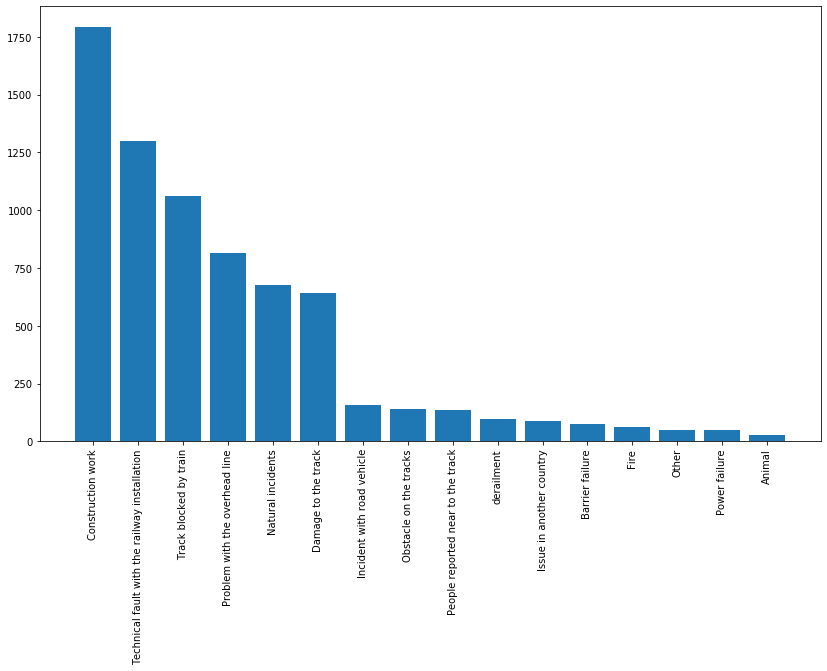

In [16]:
fig, ax = plt.subplots(figsize=(14,8))
plt.bar(Reasons_data.index,Reasons_data)
plt.xticks(rotation=90)
plt.show()

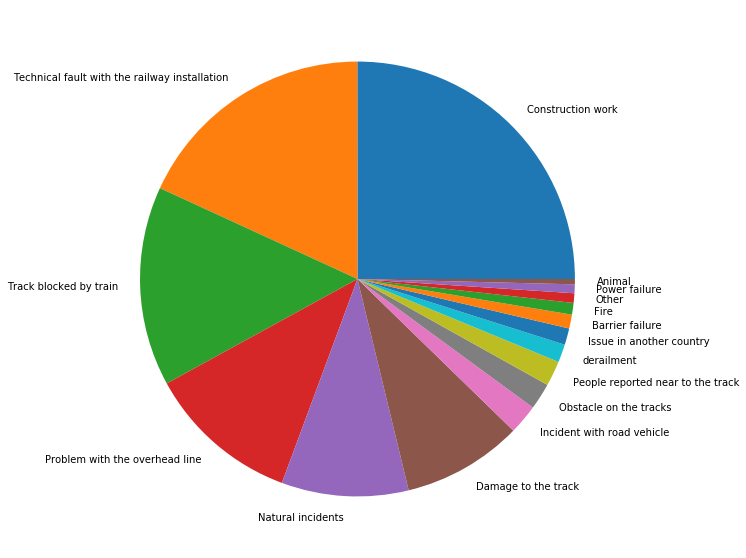

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
plt.pie(Reasons_data, labels=Reasons_data.index)
plt.show()

We can see that contruction work, technical faults with the railway installation and problems with the overhead line together are the cause of around more than 50% of the delays. Which means that with better plans, faster reaction to technical problems and maybe investing in some innovative device (for the contruction work), the CFF company could greatly reduce the amount and duration of delays in the swiss rail traffic. The Track being blocked by another track is a problem that is very likely to be caused by the delay of another train so we suppose there is not a lot that can be done there. Most other causes of delays seem to either have a very low frequency or are hard avoid.

# Plan for the Milestone 3

## Dataset

For the first analysis we only used a subset of the available data. For the next milestone we will use all the data that we managed to get during this second milestone.

## Delay analysis

We have already started doing an analysis on this topic. For the next step, we would like to analyze more deeply the geographical part (which stations are the most affected ...).So we will be able to answer the question defined in our readme => *'In which stations the delays are the most frequent?'*

## Delay reasons analysis

We found a nice data set from which we can extract information on what causes delays. The goal will be to get the "big picture" on what causes the delays and maybe tell where the CFF company should focus their efforts to reduce the amount and impact of the delays. 

## Visualisation

We will improve the visualisation of the network. Adding edges, reflecting the size of traffic on different edges and nodes by some visual aspect (thickness, color, shape). Making it iteractive like seeing stats when hovering over a certain node or edge and zooming or filtering out the little stations. We will try different tools like Folium which seems adeqaute for this task.

## Report

We will mainly focus on doing a nice data story following the narrative of "How to efficiently take trains in Switzerland and what to expect". We will certainly use Jekyll for our data story and so we need to further our knowledge of that tool.

## Things that we dropped

The database that we found on the frequency of passengers is not usefull at all as it consists of just frequency of passenger per week for each station and doesn't give much more information.
We also dropped the effect of weather on the delay as it would be too much for this project.
We won't be comparing the SBB with other country trains system as it would mean to much data exploration and data scrapping.